In [1]:
using OTSIN
using Plots
using StatsPlots
using Distributions
using DataFrames

┌ Info: Precompiling OTSIN [7b885788-be81-11e9-3333-a562fe72c8d6]
└ @ Base loading.jl:1192
ERROR: LoadError: LoadError: syntax: incomplete: "function" at /Users/michielstock/SVN_GITHUB/Ecology/OTSIN/src/fitting.jl:67 requires end
Stacktrace:
 [1] include at ./boot.jl:317 [inlined]
 [2] include_relative(::Module, ::String) at ./loading.jl:1044
 [3] include at ./sysimg.jl:29 [inlined]
 [4] include(::String) at /Users/michielstock/SVN_GITHUB/Ecology/OTSIN/src/OTSIN.jl:1
 [5] top-level scope at none:0
 [6] include at ./boot.jl:317 [inlined]
 [7] include_relative(::Module, ::String) at ./loading.jl:1044
 [8] include(::Module, ::String) at ./sysimg.jl:29
 [9] top-level scope at none:2
 [10] eval at ./boot.jl:319 [inlined]
 [11] eval(::Expr) at ./client.jl:393
 [12] top-level scope at ./none:3
in expression starting at /Users/michielstock/SVN_GITHUB/Ecology/OTSIN/src/fitting.jl:41
in expression starting at /Users/michielstock/SVN_GITHUB/Ecology/OTSIN/src/OTSIN.jl:7


ErrorException: Failed to precompile OTSIN [7b885788-be81-11e9-3333-a562fe72c8d6] to /Users/michielstock/.julia/compiled/v1.0/OTSIN/GYaVa.ji.

Here, we will simulate species interactions based on the complementary of a single numerical trait. We have four top species (e.g. pollinators) and five bottom species (e.g. plants).

In [128]:
#top_traits = (1:4) / 4
top_traits = [Normal(1.6, 0.4), Normal(2.2, 0.6), Normal(2.7, 0.3), Normal(5, 0.9)]
#top_traits = rand(4, 2)
top_names = split("ABCD", "")

#bottom_traits = (1:5) / 5
bottom_traits = [1.5, 2, 2.5, 4, 5.4]
#bottom_traits = rand(5, 2)
bottom_names = split("abcde", "")

5-element Array{SubString{String},1}:
 "a"
 "b"
 "c"
 "d"
 "e"

In [129]:
gen_inv_trait = Normal(3.7, 1.4)
spec_inv_trait = Normal(2.85, 0.25)

Normal{Float64}(μ=2.85, σ=0.25)

In [130]:
a, b = [0.20, 0.20, 0.1, 0.2, 0.3], [0.30, 0.4, 0.1, 0.2]

@assert sum(a) == sum(b)

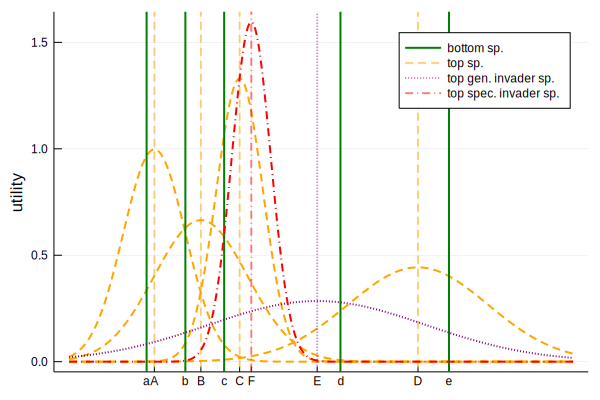

In [131]:
xvals = 0.5:0.01:7

top_prefs = [pdf.(top_traits[1], xvals) pdf.(top_traits[2], xvals) pdf.(top_traits[3], xvals) pdf.(top_traits[4], xvals)]

p_traits = plot(xvals, top_prefs, color=:orange, linewidth=2, label="", linestyle=:dash)
vline!(bottom_traits, color=:green, linewidth=2, label="bottom sp.")
vline!(mean.(top_traits), color=:orange, linewidth=2, alpha=0.5, linestyle=:dash, label="top sp.")

# gen invader
plot!(xvals, pdf.(gen_inv_trait, xvals), color=:purple, linewidth=2, label="", linestyle=:dot)
vline!([mean(gen_inv_trait)], color=:purple, linewidth=2, alpha=0.5, linestyle=:dot, label="top gen. invader sp.")

# spec invader
plot!(xvals, pdf.(spec_inv_trait, xvals), color=:red, linewidth=2, label="", linestyle=:dashdot)
vline!([mean(spec_inv_trait)], color=:red, linewidth=2, alpha=0.5, linestyle=:dashdot, label="top spec. invader sp.")


xticks!([bottom_traits; mean.(top_traits); mean.([gen_inv_trait, spec_inv_trait])],
                        [bottom_names; top_names; "E"; "F"])
ylabel!("utility")

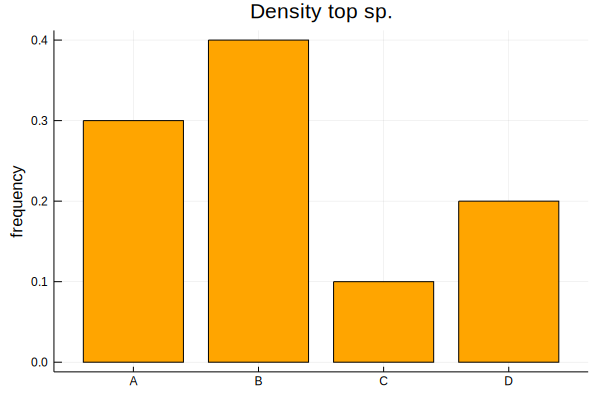

In [132]:
p_bar_bottom = bar(bottom_names, a, color=:green, label="", ylabel="frequency", title="Density bottom sp.")
p_bar_top = bar(top_names, b, color=:orange, label="", ylabel="frequency", title="Density top sp.")

In [133]:
function make_M(bottom_traits, top_traits; α=10)
    n, m = size(bottom_traits, 1), size(top_traits, 1)
    M = zeros(n, m)

    for i in 1:n
        for j in 1:m
            M[i,j] = pdf(top_traits[j], bottom_traits[i])
        end
    end
    return M
end

make_M (generic function with 1 method)

In [134]:
M = make_M(bottom_traits, top_traits, α=5)

5×4 Array{Float64,2}:
 0.96667      0.336664    0.000446101  0.000230489
 0.604927     0.628972    0.0874063    0.00171364 
 0.0793491    0.586776    1.06483      0.00935726 
 1.51897e-8   0.00738641  0.000111236  0.239103   
 2.51948e-20  4.42717e-7  3.42659e-18  0.401582   

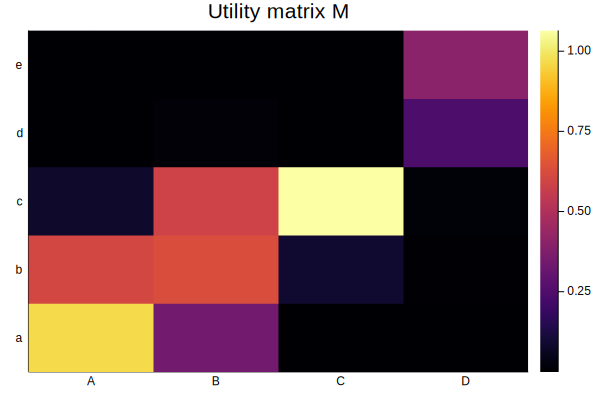

In [135]:
p_heatmap_M = heatmap(M, xticks=(1:4, top_names), yticks=(1:5, bottom_names), title="Utility matrix M")

In [136]:
l = @layout [a{0.7w}  [b; c; d]]
plot(p_traits, p_heatmap_M, p_bar_top, p_bar_bottom, layout=l, size=(800, 500))
savefig("figures/simulation_outline.svg")

Save average utility of the top species.

In [137]:
av_utilities = Matrix{Union{Nothing, Float32}}(nothing, 6, 6)

6×6 Array{Union{Nothing, Float32},2}:
 nothing  nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing  nothing

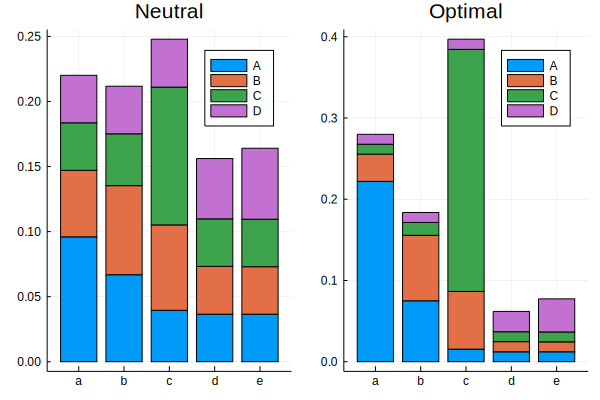

In [138]:
Ql = optimaltransport(M, λ=1)
Qh = optimaltransport(M, λ=3)
p_neutral = groupedbar(bottom_names, Ql, labels=top_names, bar_position = :stack,
        title="Neutral")
p_optimal_free = groupedbar(bottom_names, Qh, labels=top_names, bar_position = :stack,
        title="Optimal")

av_utilities[3,1:4] = sum(Qh .* M, dims=1)[:]

plot(p_neutral, p_optimal_free)

In [139]:
report_utility(Qh, M, bottom_names, top_names)

Bottom species
	a: utility = 0.8068078637145164, entropy = 0.711671677000108
	b: utility = 0.5304552121227104, entropy = 1.1195923368430565
	c: utility = 0.9074732624488523, entropy = 0.7590990359361104
	d: utility = 0.09810677528178288, entropy = 1.329346064397185
	e: utility = 0.2114364091334047, entropy = 1.2119247447785364

Top species
	A: utility = 0.7752413828878827, entropy = 0.9914697042063726
	B: utility = 0.4943848422217774, entropy = 1.3606678730718478
	C: utility = 0.9092055792346669, entropy = 0.6292444624517247
	D: utility = 0.21868262896516255, entropy = 1.4744595480768175

Average utility = 0.7060371999132843
Average entropy = 2.287170778065524


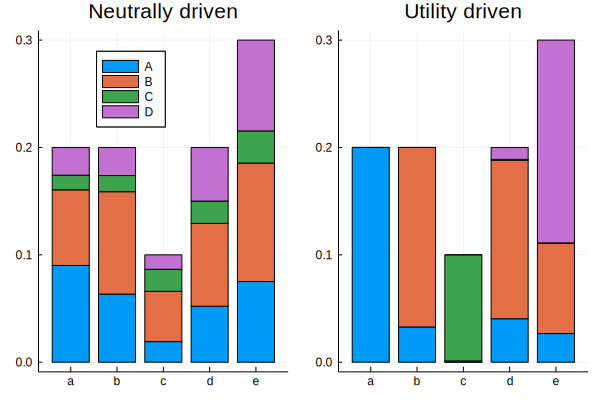

In [140]:
Ql = optimaltransport(M, a, b, λ=1)
Qh = optimaltransport(M, a, b, λ=20)

p_ot_neutral = groupedbar(bottom_names, Ql, labels=top_names, bar_position = :stack,
        title="Neutrally driven", legend=:top)
p_ot_utility = groupedbar(bottom_names, Qh, labels=top_names, bar_position = :stack,
        title="Utility driven", legend=:top)

av_utilities[1,1:4] = sum(Qh .* M, dims=1)[:]
av_utilities[2,1:4] = sum(Ql .* M, dims=1)[:]

plot(p_ot_neutral, p_ot_utility)

In [141]:
report_utility(Ql, M, bottom_names, top_names)

Bottom species
	a: utility = 0.5540084052666666, entropy = 1.174474590002911
	b: utility = 0.498530959562539, entropy = 1.1781787798836245
	c: utility = 0.5094980845006655, entropy = 1.267315292265173
	d: utility = 0.06254401646080698, entropy = 1.2997653789247459
	e: utility = 0.11326178584362162, entropy = 1.3016892296671878

Top species
	A: utility = 0.4232369899231811, entropy = 1.516602202102876
	B: utility = 0.2793017777886502, entropy = 1.5712716242066187
	C: utility = 0.23161552969091787, entropy = 1.5698083451865148
	D: utility = 0.23046094412112217, entropy = 1.42255362285557

Average utility = 0.30794554988573064
Average entropy = 2.8048350952369434


In [142]:
report_utility(Qh, M, bottom_names, top_names)

Bottom species
	a: utility = 0.9666636075177621, entropy = 0.00013213674446453422
	b: utility = 0.6250238354575499, entropy = 0.4465662117810258
	c: utility = 1.0590492961661013, entropy = 0.06537894998453257
	d: utility = 0.01874456773965711, entropy = 0.7285474327879808
	e: utility = 0.2528373105356771, entropy = 0.8732492990325957

Top species
	A: utility = 0.7106664481735534, entropy = 0.9979384994669072
	B: utility = 0.2673525259845419, entropy = 1.077769054939136
	C: utility = 1.0518546236504056, entropy = 0.07399317142239457
	D: utility = 0.3925505556442431, entropy = 0.214643746612884

Average utility = 0.5038365183397719
Average entropy = 2.0606714641142103


## Removing a plant

Remove the plant e, which has a highly specific interaction with pollinator E.

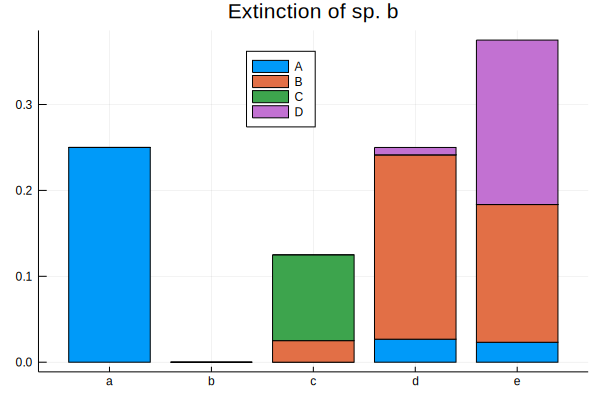

In [143]:
a_removal = copy(a)
a_removal[2] = 0.0
a_removal ./ sum(a_removal)

Q_extinction = optimaltransport(M, a_removal, b, λ=20)

av_utilities[4,1:4] = sum(Q_extinction .* M, dims=1)[:]

p_extincition = groupedbar(bottom_names, Q_extinction, labels=top_names, bar_position = :stack,
        title="Extinction of sp. b", legend=:top)

In [144]:
Q_extinction

5×4 Array{Float64,2}:
 0.249994    5.82245e-6  1.9607e-12  2.7027e-12 
 0.0         0.0         0.0         0.0        
 1.42178e-7  0.0250968   0.0999031   9.40041e-11
 0.0267972   0.214577    5.20059e-5  0.00857365 
 0.0232085   0.16032     4.49413e-5  0.191426   

## Adding a generalist invader

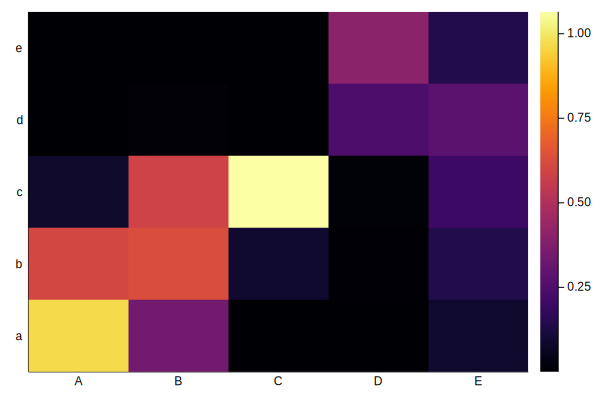

In [145]:
M_gen_inv = make_M(bottom_traits, [top_traits; gen_inv_trait])

top_names_inv = [top_names..., "E"]

heatmap(M_gen_inv, xticks=(1:5, top_names_inv), yticks=(1:5, bottom_names))

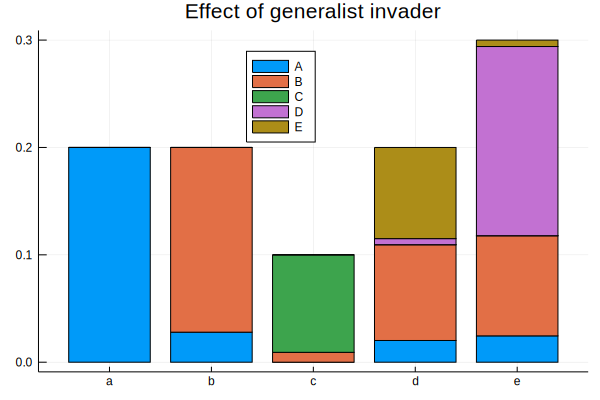

In [146]:
b_inv = OTSIN.normalize([b; 0.1])

Q_gen_inv = optimaltransport(M_gen_inv, a, b_inv, λ=20.0)

av_utilities[5,1:5] = sum(Q_gen_inv .* M_gen_inv, dims=1)[:]

p_gen_inv = groupedbar(bottom_names, Q_gen_inv, labels=[top_names; "E"], bar_position = :stack,
        title="Effect of generalist invader", legend=:top)

In [147]:
report_utility(Q_gen_inv, M_gen_inv, bottom_names, top_names_inv)

Bottom species
	a: utility = 0.9666622157123042, entropy = 0.0001572266149211347
	b: utility = 0.6256089505275302, entropy = 0.4047147298519674
	c: utility = 1.0208407311172352, entropy = 0.3071774913938845
	d: utility = 0.12827137819435655, entropy = 1.058432967397584
	e: utility = 0.23855815650357548, entropy = 0.9605044700630025

Top species
	A: utility = 0.770937185093591, entropy = 0.870583045014232
	B: utility = 0.31421320179213796, entropy = 1.1408492238971273
	C: utility = 1.0634402414625936, entropy = 0.010849094450469351
	D: utility = 0.39654377947616765, entropy = 0.13823086016529135
	E: utility = 0.2691165555852172, entropy = 0.24302415850082287

Average utility = 0.5177553380408609
Average entropy = 2.168638212099216


### Effect of a specialist invader

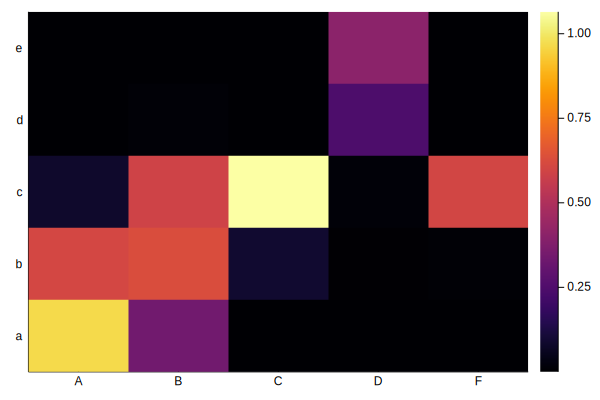

In [148]:
M_spec_inv = make_M(bottom_traits, [top_traits; spec_inv_trait])

top_names_inv = [top_names..., "F"]

heatmap(M_spec_inv, xticks=(1:5, top_names_inv), yticks=(1:5, bottom_names))

In [149]:
Q_spec_inv = optimaltransport(M_spec_inv, a, b_inv, λ=20.0)

5×5 Array{Float64,2}:
 0.2         2.56509e-6  3.50745e-12  2.39999e-12  1.56398e-9
 0.0279605   0.172041    3.87165e-9   4.79369e-10  3.34669e-7
 5.77367e-8  0.00561222  0.090715     4.23719e-11  0.00366341
 0.0259118   0.114258    0.000112445  0.00920207   0.0505169 
 0.0188546   0.0717221   8.16383e-5   0.172616     0.0367285 

In [150]:
av_utilities[6,[1, 2, 3, 4, 6]] = sum(Q_spec_inv .* M_spec_inv, dims=1)[:]

5-element Array{Float64,1}:
 0.2102484390492402   
 0.11234694856373677  
 0.09659576915090086  
 0.07151976902111769  
 0.0021961044849132124

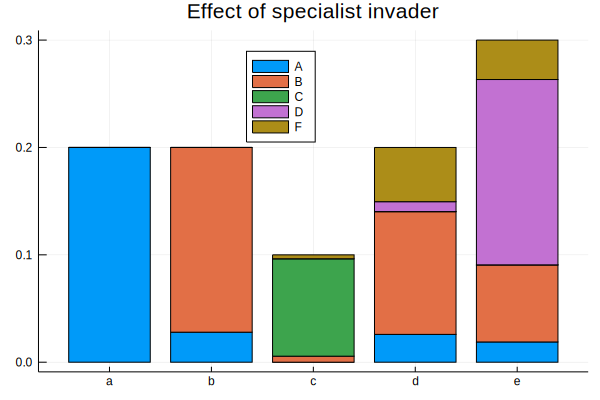

In [151]:
p_spec_inv =  groupedbar(bottom_names, Q_spec_inv, labels=[top_names; "F"], bar_position = :stack,
        title="Effect of specialist invader", legend=:top)

In [152]:
plot(p_ot_utility, p_ot_neutral, p_optimal_free, p_extincition, p_gen_inv, p_spec_inv,
        layout=(2, 3), size=(1500, 1.5*500))

savefig("figures/simulation_settings.svg")

In [153]:
p_ut_a, p_ut_b = pert_utility(M, a, b, λ=20)
p_entr_a, p_entr_b = pert_entropy(M, a, b, λ=20)

plot_pert_bottom = scatter(bottom_names, [p_ut_a p_entr_a],
    label=["relative effect utility", "relative effect entropy"],
    title="Perturbations bottom sp.", markershape=[:circle :utriangle])
plot_pert_top = scatter(top_names, [p_ut_b p_entr_b],
    label=["relative effect utility", "relative effect entropy"],
    legend=:none, title="Perturbations top sp.", markershape=[:circle :utriangle])

plot(plot_pert_bottom, plot_pert_top, layout=grid(2, 1), size=(600, 400))
savefig("figures/perturbation.svg")

In [154]:
results = DataFrame(av_utilities, [:A, :B, :C, :D, :E, :F])

,A,B,C,D,E,F
,Union…,Union…,Union…,Union…,Union…,Union…
1,0.2132,0.106941,0.105185,0.0785101,,
2,0.126971,0.111721,0.0231616,0.0460922,,
3,0.261148,0.103737,0.318668,0.022485,,
4,0.241662,0.0163132,0.106379,0.0789234,,
5,0.210256,0.114259,0.0966764,0.0720989,0.0244651,
6,0.210248,0.112347,0.0965958,0.0715198,,0.0021961


In [155]:
println(results)

6×6 DataFrame
│ Row │ A        │ B         │ C         │ D         │ E         │ F         │
│     │ Union…   │ Union…    │ Union…    │ Union…    │ Union…    │ Union…    │
├─────┼──────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ 1   │ 0.2132   │ 0.106941  │ 0.105185  │ 0.0785101 │           │           │
│ 2   │ 0.126971 │ 0.111721  │ 0.0231616 │ 0.0460922 │           │           │
│ 3   │ 0.261148 │ 0.103737  │ 0.318668  │ 0.022485  │           │           │
│ 4   │ 0.241662 │ 0.0163132 │ 0.106379  │ 0.0789234 │           │           │
│ 5   │ 0.210256 │ 0.114259  │ 0.0966764 │ 0.0720989 │ 0.0244651 │           │
│ 6   │ 0.210248 │ 0.112347  │ 0.0965958 │ 0.0715198 │           │ 0.0021961 │
